✅ Libraries imported successfully!

✅ Dataset loaded successfully!
Shape of dataset: (45593, 20)

First 5 rows of dataset:
        ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                   37                     4.9   
1  0xb379     BANGRES18DEL02                   34                     4.5   
2  0x5d6d     BANGRES19DEL01                   23                     4.4   
3  0x7a6a    COIMBRES13DEL02                   38                     4.7   
4  0x70a2     CHENRES12DEL01                   32                     4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793            

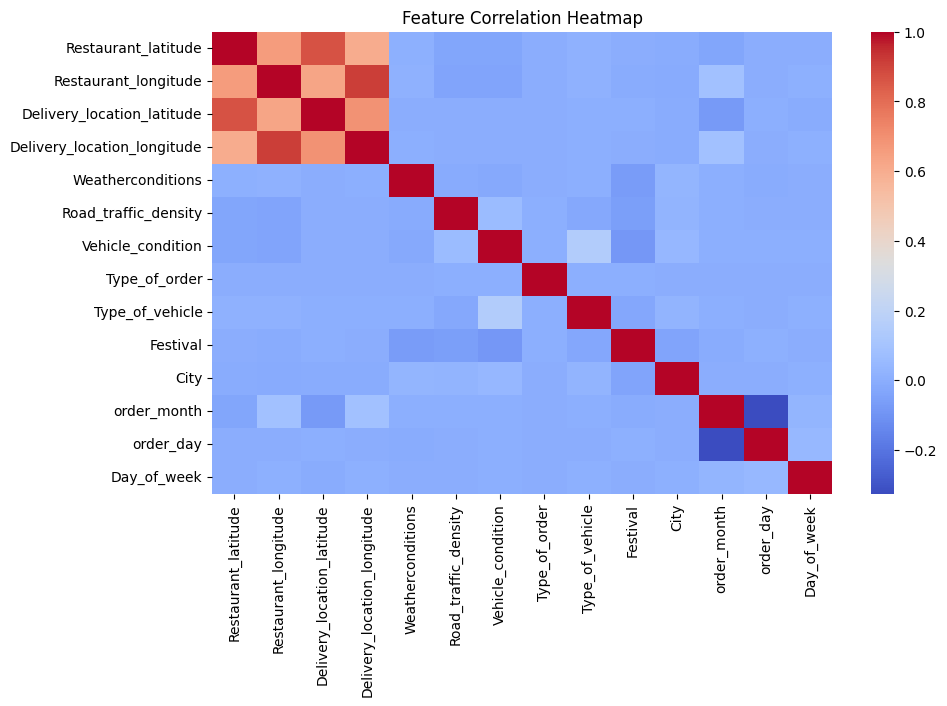


✅ Dataset split into training and testing sets!
Training set shape: (36474, 22)
Testing set shape: (9119, 22)

✅ Data cleaning completed successfully!

✅ Models trained successfully!

📊 Model Performance Comparison:
               Model  R² Score       MAE      RMSE
0  Linear Regression  0.000194  7.575788  9.362750
1      Random Forest  0.768053  3.534630  4.509616


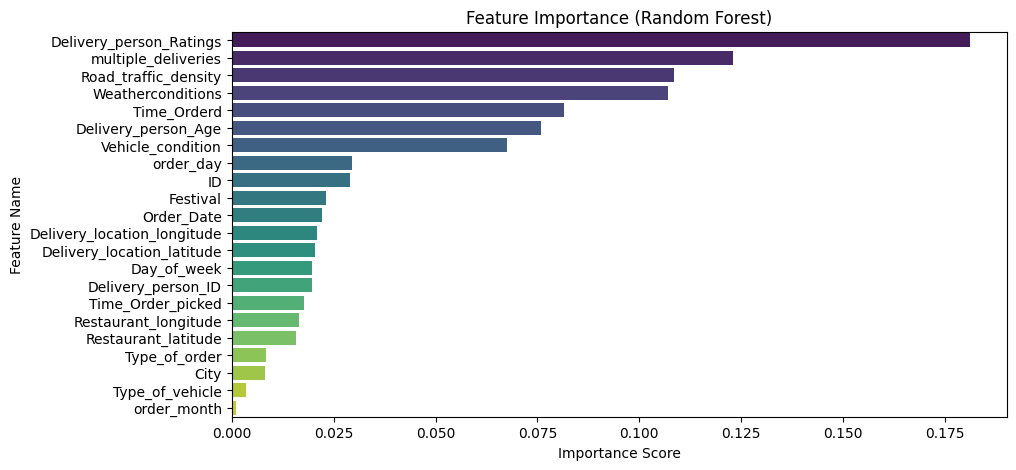

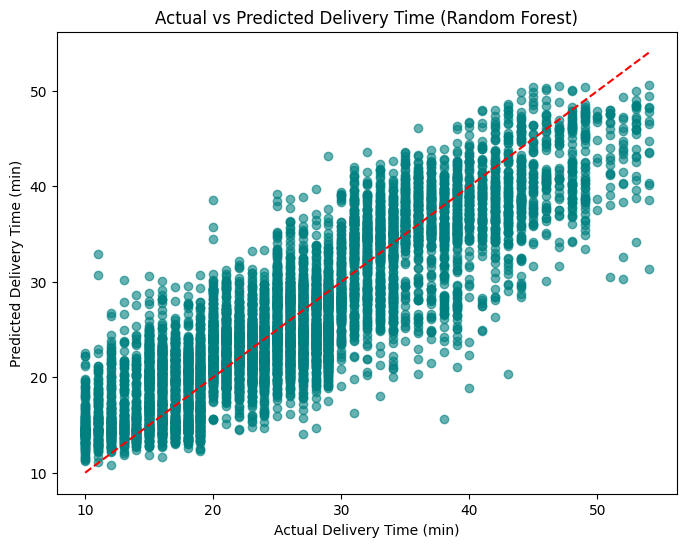

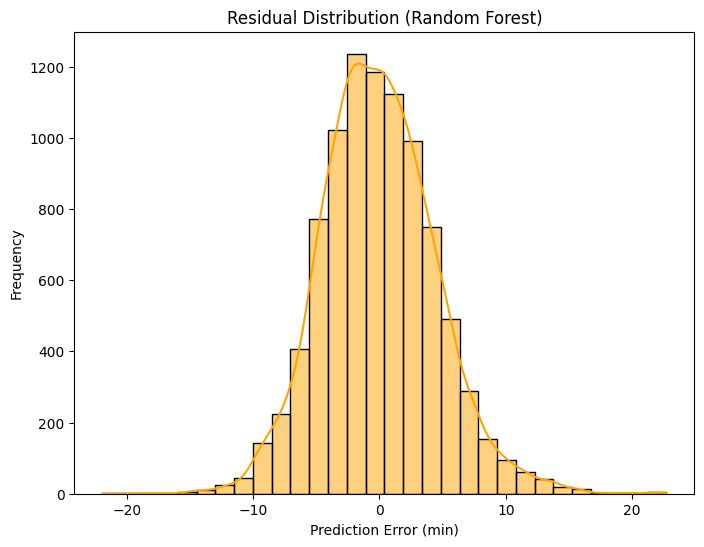

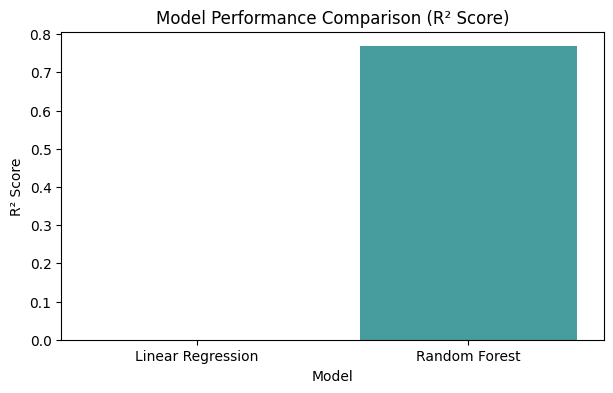


📄 First 10 Predictions:
       Actual Time  Predicted Time (RF)
7725          44.0                42.67
949           41.0                44.79
44893         39.0                36.24
42071         38.0                42.19
27091         38.0                33.93
18398         22.0                23.56
13996         14.0                15.69
10192         17.0                27.96
8565          22.0                20.74
15253         29.0                27.01

🎉 Project completed successfully! All steps executed properly.


In [3]:
# ============================================================
# 🏁 Step 1: Import All Required Libraries
# ============================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expressions for cleaning string data
import re

# Machine learning tools from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")


# ============================================================
# 📂 Step 2: Load the Dataset
# ============================================================

# Provide the correct file path for your dataset
data_path = "E:\\Datasets\\Food delivery\\train.csv"

# Read the CSV file using pandas
train = pd.read_csv(data_path)

# Display basic information about the dataset
print("\n✅ Dataset loaded successfully!")
print("Shape of dataset:", train.shape)
print("\nFirst 5 rows of dataset:")
print(train.head())


# ============================================================
# 🔍 Step 3: Explore the Dataset (EDA - Exploratory Data Analysis)
# ============================================================

# Display dataset info (column names, data types, missing values count)
print("\n📊 Dataset Information:")
print(train.info())

# Summary statistics for numeric columns
print("\n📈 Statistical Summary:")
print(train.describe())

# Check total missing values in each column
print("\n🔎 Missing Values in Each Column:")
print(train.isnull().sum())

# Display unique value counts for categorical columns
print("\n🧩 Unique Values in Each Categorical Column:")
for col in train.select_dtypes('object').columns:
    print(f"{col}: {train[col].nunique()}")


# ============================================================
# 🧹 Step 4: Handle Missing Values
# ============================================================

# Fill missing numeric values with median (robust against outliers)
num_cols = train.select_dtypes(['int64', 'float64']).columns
train[num_cols] = train[num_cols].fillna(train[num_cols].median())

# Fill missing categorical values with mode (most frequent value)
cat_cols = train.select_dtypes('object').columns
for col in cat_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)

print("\n✅ Missing values handled successfully!")


# ============================================================
# ⚙️ Step 5: Feature Engineering
# ============================================================

# Convert 'Order_Date' to datetime format to extract useful date parts
train['Order_Date'] = pd.to_datetime(train['Order_Date'], errors='coerce')

# Extract additional features from date
train['order_month'] = train['Order_Date'].dt.month     # Month number (1–12)
train['order_day'] = train['Order_Date'].dt.day         # Day of month (1–31)
train['Day_of_week'] = train['Order_Date'].dt.day_name() # Day name (Monday–Sunday)

# Encode categorical columns using LabelEncoder (convert text → numeric)
encode_cols = ['Weatherconditions', 'Road_traffic_density', 'Type_of_order',
               'Type_of_vehicle', 'Festival', 'City', 'Day_of_week']

le = LabelEncoder()
for col in encode_cols:
    if col in train.columns:
        train[col] = le.fit_transform(train[col].astype(str))

# Drop unnecessary or ID-based columns that don’t help prediction
drop_cols = ['id', 'delivery_person_id', 'time_orderd', 'time_order_picked']
train.drop(columns=drop_cols, inplace=True, errors='ignore')

print("\n✅ Feature Engineering completed!")


# ============================================================
# 🎨 Step 6: Visualize Feature Correlations
# ============================================================

# Display a heatmap of correlations among numeric features
plt.figure(figsize=(10, 6))
sns.heatmap(train.select_dtypes(include=['number']).corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


# ============================================================
# 🎯 Step 7: Define Features (X) and Target (y)
# ============================================================

# Check if target column exists
if 'Time_taken(min)' not in train.columns:
    raise ValueError("❌ Target column 'Time_taken(min)' not found in dataset.")

# Separate target variable (what we want to predict)
y = train['Time_taken(min)']

# Features (input columns used for prediction)
X = train.drop(columns=['Time_taken(min)'])

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n✅ Dataset split into training and testing sets!")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


# ============================================================
# 🧽 Step 8: Data Cleaning Function
# ============================================================

def clean_and_convert(value):
    """
    This function cleans and converts string values into numeric.
    Handles cases like:
    - '28 min' → 28
    - '(min) 45' → 45
    - '0x9f31' (hex) → converted to integer
    """
    if isinstance(value, str):
        value = value.strip()
        # Handle hexadecimal strings
        if '0x' in value.lower():
            try:
                return int(value, 16)
            except:
                return np.nan
        # Extract numeric value from strings
        num_match = re.findall(r'[-+]?\d*\.\d+|\d+', value)
        if num_match:
            return float(num_match[0])
        return np.nan  # Return NaN if no number is found
    return value  # Return unchanged if already numeric


# Apply cleaning function to all columns
for col in X_train.columns:
    X_train[col] = X_train[col].apply(clean_and_convert)
    X_test[col] = X_test[col].apply(clean_and_convert)

# Apply cleaning to target variable as well
y_train = y_train.apply(clean_and_convert)
y_test = y_test.apply(clean_and_convert)

# Convert to numeric type and replace missing values with 0
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
y_train = pd.to_numeric(y_train, errors='coerce').fillna(0)
y_test = pd.to_numeric(y_test, errors='coerce').fillna(0)

print("\n✅ Data cleaning completed successfully!")


# ============================================================
# 🤖 Step 9: Train Machine Learning Models
# ============================================================

# --- Model 1: Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# --- Model 2: Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n✅ Models trained successfully!")


# ============================================================
# 📏 Step 10: Evaluate Model Performance
# ============================================================

# Compare model performance using key metrics
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R² Score': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_rf))]
})

print("\n📊 Model Performance Comparison:")
print(results)


# ============================================================
# 📈 Step 11: Visualize Model Results
# ============================================================

# --- (a) Feature Importance from Random Forest ---
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_imp.values, y=feature_imp.index, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

# --- (b) Scatter Plot: Actual vs Predicted ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='teal')
plt.xlabel("Actual Delivery Time (min)")
plt.ylabel("Predicted Delivery Time (min)")
plt.title("Actual vs Predicted Delivery Time (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# --- (c) Residual Plot (Error Distribution) ---
residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Residual Distribution (Random Forest)")
plt.xlabel("Prediction Error (min)")
plt.ylabel("Frequency")
plt.show()

# --- (d) Bar Plot: Model Performance Comparison ---
plt.figure(figsize=(7, 4))
sns.barplot(x='Model', y='R² Score', data=results, palette='mako')
plt.title("Model Performance Comparison (R² Score)")
plt.show()


# ============================================================
# 🧾 Step 12: Prepare Final Submission Data
# ============================================================

# Create a comparison DataFrame between actual and predicted values
submission = pd.DataFrame({
    'Actual Time': y_test,
    'Predicted Time (RF)': y_pred_rf
})

print("\n📄 First 10 Predictions:")
print(submission.head(10))

print("\n🎉 Project completed successfully! All steps executed properly.")
